<a href="https://colab.research.google.com/github/Ariara61/ESAA/blob/main/Keras_CNN_Dog_or_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
filenames = os.listdir("/content/drive/MyDrive/Dog or Cat/train_1200")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

filename  category
0  cat.278.jpg         0
1  cat.280.jpg         0
2   cat.28.jpg         0
3  cat.281.jpg         0
4  cat.282.jpg         0

In [6]:
df.tail()

filename  category
1195  cat.274.jpg         0
1196  cat.275.jpg         0
1197  cat.276.jpg         0
1198  cat.277.jpg         0
1199  cat.279.jpg         0

<Axes: >

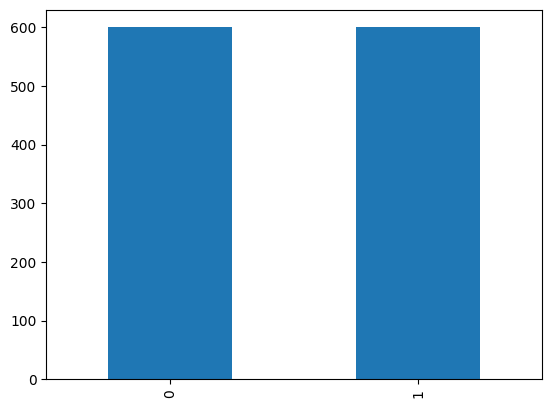

In [7]:
df['category'].value_counts().plot.bar()

# See sample image

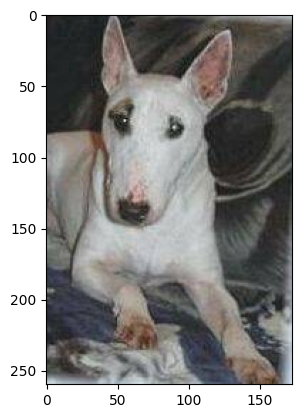

In [8]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Dog or Cat/train_1200/"+sample)
plt.imshow(image)

# Build Model

* 입력 레이어(Input Layer): 이미지 데이터를 입력받음. 입력받은 이미지를 단일 차원 배열로 재구성. 예를 들어, 64x64 크기의 이미지가 있을 경우, 이를 (4096, 1) 크기의 배열로 변환.

* 합성곱 레이어(Conv Layer): 이미지에서 특징을 추출. 합성곱 연산을 통해 이미지의 중요한 특성을 식별하고, 이를 기반으로 다음 레이어로 전달.

* 풀링 레이어(Pooling Layer): 합성곱을 거친 입력 이미지의 공간적 크기를 줄임. 풀링 연산은 이미지의 크기를 감소시키지만 중요한 특징은 유지하게 해, 계산 효율성을 높이고 과적합을 방지하는 데 도움이 됨.

* 완전 연결 레이어(Fully Connected Layer): 네트워크의 한 레이어에서 다른 레이어로 연결을 제공. 이전 레이어의 모든 뉴런이 다음 레이어의 모든 뉴런과 연결되어 있는 구조. 이를 통해 네트워크는 학습한 특징을 기반으로 분류나 예측을 수행할 수 있음.

* 출력 레이어(Output Layer): 예측된 값을 출력. 네트워크의 마지막 레이어로, 문제의 종류(분류, 회귀 등)에 따라서 다른 활성화 함수를 사용할 수 있음. 예측 결과는 이 레이어를 통해 도출됨.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# Callbacks

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

* Overfitting 방지하기 위해 10 epoch동안 val_loss 줄어들지 않으면 학습 중단

In [11]:
earlystop = EarlyStopping(patience=10)

* Learning Rate Reduction: 모델의 정확도가 연속적으로 두 번의 학습 단계에서 개선되지 않는 경우, 학습률을 낮춤

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data
* Image generator을 사용할 때, class_model = "categorical"로 설정
* 이를 위해 category 열을 문자열로 변환해야 함
* 1 = dog, 0 = cat

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

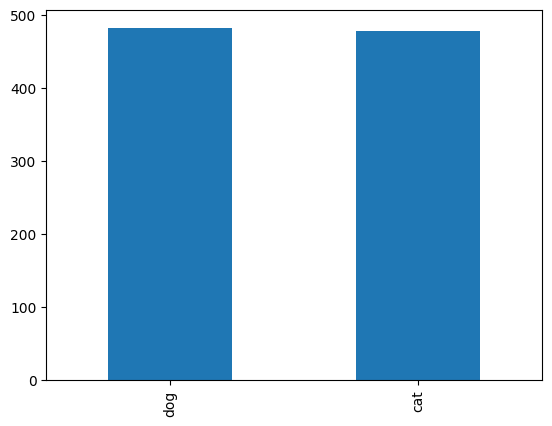

In [16]:
train_df['category'].value_counts().plot.bar()

<Axes: >

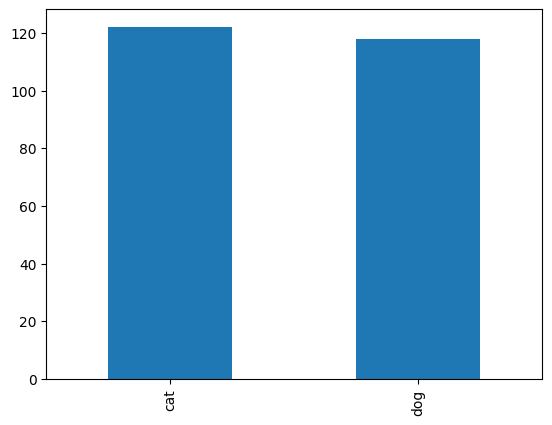

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training Generator

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/Dog or Cat/train_1200/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 960 validated image filenames belonging to 2 classes.


## Validation Generator

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/Dog or Cat/train_1200/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 240 validated image filenames belonging to 2 classes.


# See how our generator work

In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/Dog or Cat/train_1200/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


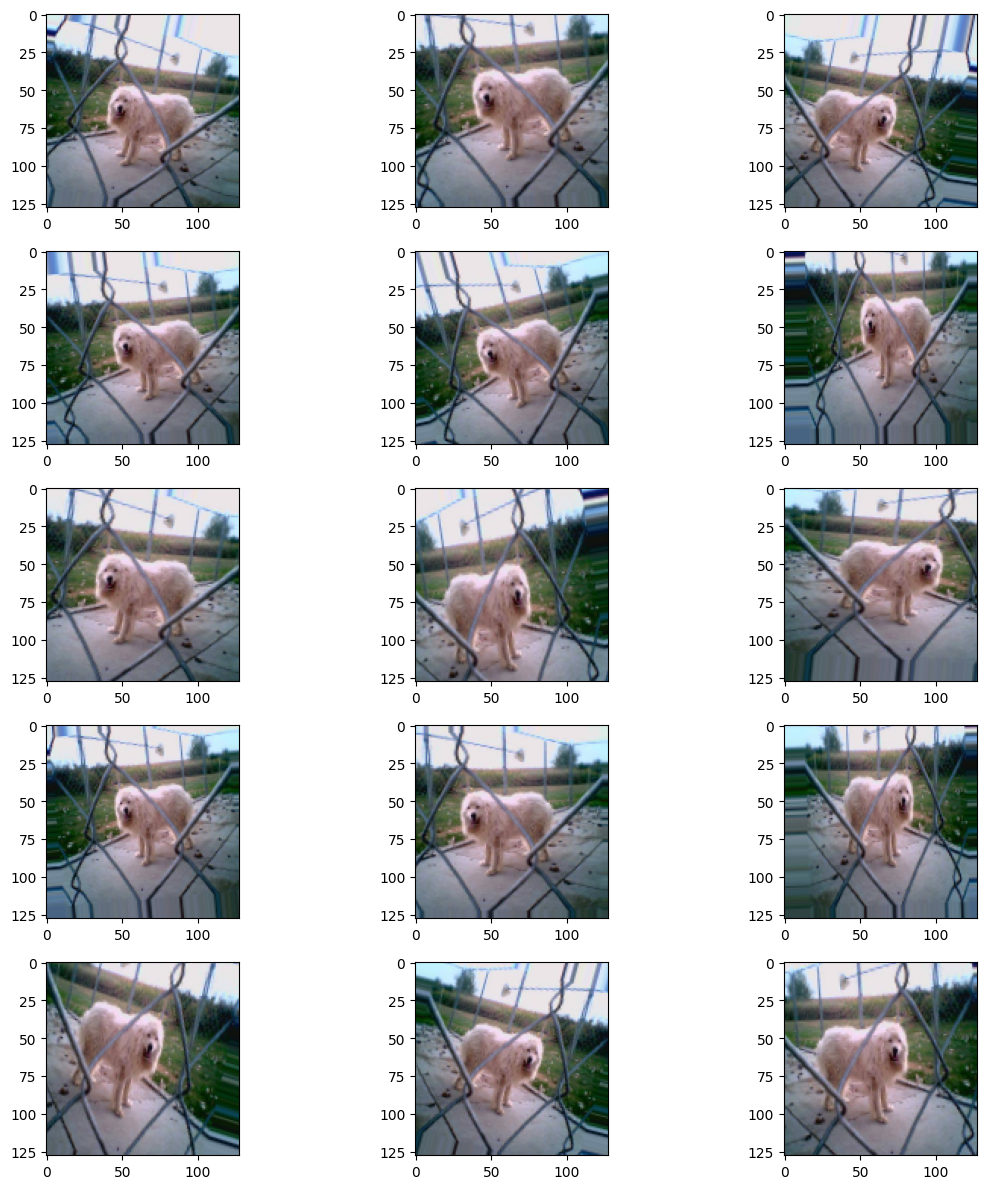

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [23]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-23-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 1.2694 - accuracy: 0.5833

64/64 [==============================] - 100s 2s/step - loss: 1.2694 - accuracy: 0.5833 - val_loss: 7.4492 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 0.9565 - accuracy: 0.5990

64/64 [==============================] - 75s 1s/step - loss: 0.9565 - accuracy: 0.5990 - val_loss: 8.6508 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 0.9128 - accuracy: 0.5844

64/64 [==============================] - 82s 1s/step - loss: 0.9128 - accuracy: 0.5844 - val_loss: 6.0036 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - ETA: 0s - loss: 0.8331 - accuracy: 0.6042

64/64 [==============================] - 68s 1s/step - loss: 0.8331 - accuracy: 0.6042 - val_loss: 1.0470 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.6427

64/64 [==============================] - 86s 1s/step - loss: 0.7187 - accuracy: 0.6427 - val_loss: 2.0163 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.6510

64/64 [==============================] - 71s 1s/step - loss: 0.6824 - accuracy: 0.6510 - val_loss: 2.4442 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.6615

64/64 [==============================] - 66s 1s/step - loss: 0.6960 - accuracy: 0.6615 - val_loss: 0.8606 - val_accuracy: 0.6125 - lr: 0.0010
Epoch 8/50
64/64 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.6562

64/64 [==============================] - 66s 1s/step - loss: 0.6522 - accuracy: 0.6562 - val_loss: 0.8044 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 9/50
64/64 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.6812

64/64 [==============================] - 63s 980ms/step - loss: 0.6259 - accuracy: 0.6812 - val_loss: 0.6336 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 10/50
64/64 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.6885

64/64 [==============================] - 67s 1s/step - loss: 0.6124 - accuracy: 0.6885 - val_loss: 0.6087 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 11/50
64/64 [==============================] - ETA: 0s - loss: 0.6127 - accuracy: 0.7094

64/64 [==============================] - 65s 1s/step - loss: 0.6127 - accuracy: 0.7094 - val_loss: 0.6183 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 12/50
64/64 [==============================] - ETA: 0s - loss: 0.5895 - accuracy: 0.7125

64/64 [==============================] - 64s 1s/step - loss: 0.5895 - accuracy: 0.7125 - val_loss: 0.5961 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 13/50
64/64 [==============================] - ETA: 0s - loss: 0.5583 - accuracy: 0.7323

64/64 [==============================] - 62s 967ms/step - loss: 0.5583 - accuracy: 0.7323 - val_loss: 0.6468 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 14/50
64/64 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.7437

64/64 [==============================] - 64s 1s/step - loss: 0.5534 - accuracy: 0.7437 - val_loss: 0.5614 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 15/50
64/64 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.7500

64/64 [==============================] - 63s 968ms/step - loss: 0.5367 - accuracy: 0.7500 - val_loss: 0.6155 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 16/50
64/64 [==============================] - ETA: 0s - loss: 0.5251 - accuracy: 0.7458

64/64 [==============================] - 62s 969ms/step - loss: 0.5251 - accuracy: 0.7458 - val_loss: 0.6375 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 17/50
64/64 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.7615

64/64 [==============================] - 62s 955ms/step - loss: 0.5245 - accuracy: 0.7615 - val_loss: 0.5884 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 18/50
64/64 [==============================] - ETA: 0s - loss: 0.5264 - accuracy: 0.7448

64/64 [==============================] - 62s 964ms/step - loss: 0.5264 - accuracy: 0.7448 - val_loss: 0.5294 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 19/50
64/64 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.7448

64/64 [==============================] - 63s 975ms/step - loss: 0.5253 - accuracy: 0.7448 - val_loss: 0.5842 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 20/50
64/64 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.7510

64/64 [==============================] - 64s 989ms/step - loss: 0.5019 - accuracy: 0.7510 - val_loss: 0.6087 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 21/50
64/64 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.7948

64/64 [==============================] - 64s 986ms/step - loss: 0.4780 - accuracy: 0.7948 - val_loss: 0.5647 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 22/50
64/64 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.7615

64/64 [==============================] - 63s 982ms/step - loss: 0.5046 - accuracy: 0.7615 - val_loss: 0.5241 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 23/50
64/64 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.7656

64/64 [==============================] - 64s 984ms/step - loss: 0.4944 - accuracy: 0.7656 - val_loss: 0.6885 - val_accuracy: 0.6958 - lr: 0.0010
Epoch 24/50
64/64 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.7708

64/64 [==============================] - 63s 978ms/step - loss: 0.4763 - accuracy: 0.7708 - val_loss: 0.5639 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 25/50
64/64 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.7781

64/64 [==============================] - 62s 975ms/step - loss: 0.4582 - accuracy: 0.7781 - val_loss: 0.5585 - val_accuracy: 0.7458 - lr: 0.0010
Epoch 26/50
64/64 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.7958

64/64 [==============================] - 65s 1s/step - loss: 0.4475 - accuracy: 0.7958 - val_loss: 0.4694 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 27/50
64/64 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.7906

64/64 [==============================] - 62s 972ms/step - loss: 0.4864 - accuracy: 0.7906 - val_loss: 0.5109 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 28/50
64/64 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.7844

64/64 [==============================] - 65s 1s/step - loss: 0.4770 - accuracy: 0.7844 - val_loss: 0.4881 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 29/50
64/64 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.7969

64/64 [==============================] - 65s 1s/step - loss: 0.4551 - accuracy: 0.7969 - val_loss: 0.4698 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 30/50
64/64 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.7927

64/64 [==============================] - 60s 939ms/step - loss: 0.4480 - accuracy: 0.7927 - val_loss: 0.5290 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 31/50
64/64 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8260

64/64 [==============================] - 62s 971ms/step - loss: 0.4081 - accuracy: 0.8260 - val_loss: 0.4852 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 32/50
64/64 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8125

64/64 [==============================] - 63s 978ms/step - loss: 0.4139 - accuracy: 0.8125 - val_loss: 0.5447 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 33/50
64/64 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.7990

64/64 [==============================] - 62s 971ms/step - loss: 0.4438 - accuracy: 0.7990 - val_loss: 0.4586 - val_accuracy: 0.7958 - lr: 0.0010
Epoch 34/50
64/64 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.7958

64/64 [==============================] - 63s 975ms/step - loss: 0.4268 - accuracy: 0.7958 - val_loss: 1.2962 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 35/50
64/64 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.8302

64/64 [==============================] - 62s 970ms/step - loss: 0.3841 - accuracy: 0.8302 - val_loss: 0.5078 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 36/50
64/64 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8323

64/64 [==============================] - 62s 969ms/step - loss: 0.3768 - accuracy: 0.8323 - val_loss: 0.4430 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 37/50
64/64 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.8250

64/64 [==============================] - 65s 1s/step - loss: 0.3878 - accuracy: 0.8250 - val_loss: 0.7310 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 38/50
64/64 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.8271

64/64 [==============================] - 62s 967ms/step - loss: 0.3922 - accuracy: 0.8271 - val_loss: 0.6179 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 39/50
64/64 [==============================] - ETA: 0s - loss: 0.3797 - accuracy: 0.8250

64/64 [==============================] - 65s 1s/step - loss: 0.3797 - accuracy: 0.8250 - val_loss: 0.5783 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 40/50
64/64 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8135

64/64 [==============================] - 62s 965ms/step - loss: 0.4063 - accuracy: 0.8135 - val_loss: 0.5733 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 41/50
64/64 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8292

64/64 [==============================] - 63s 982ms/step - loss: 0.3833 - accuracy: 0.8292 - val_loss: 0.6410 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 42/50
64/64 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.8177

64/64 [==============================] - 63s 981ms/step - loss: 0.4292 - accuracy: 0.8177 - val_loss: 0.6392 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 43/50
64/64 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8573

64/64 [==============================] - 62s 965ms/step - loss: 0.3418 - accuracy: 0.8573 - val_loss: 0.4986 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 44/50
64/64 [==============================] - ETA: 0s - loss: 0.3983 - accuracy: 0.8302

64/64 [==============================] - 65s 1s/step - loss: 0.3983 - accuracy: 0.8302 - val_loss: 1.0139 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 45/50
64/64 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8375

64/64 [==============================] - 61s 945ms/step - loss: 0.3870 - accuracy: 0.8375 - val_loss: 0.5871 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 46/50
64/64 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.8125

64/64 [==============================] - 61s 960ms/step - loss: 0.4186 - accuracy: 0.8125 - val_loss: 0.5418 - val_accuracy: 0.7333 - lr: 0.0010


# Save Model

In [24]:
model.save_weights("model.h5")

# Virtualize Training

KeyError: ignored

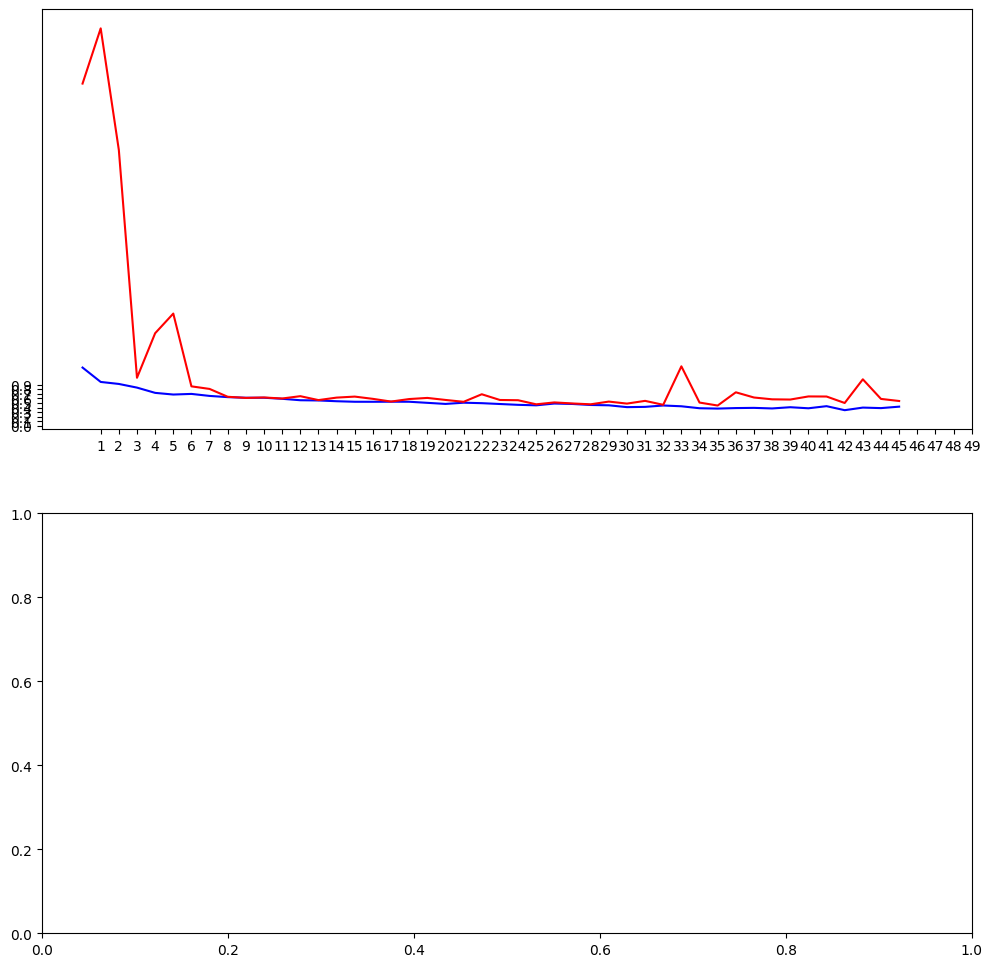

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [27]:
test_filenames = os.listdir("/content/drive/MyDrive/Dog or Cat/test_600")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [28]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/drive/MyDrive/Dog or Cat/test_600/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 602 validated image filenames.


# Predict

In [29]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-29-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


* 범주형 분류에서 각 범주에 대해 가장 높은 확률을 가진 범주를 선택

In [30]:
test_df['category'] = np.argmax(predict, axis=-1)

* train_generator.class_indices를 사용하여 예측된 범줄를 generator 클래스로 변환

In [31]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [32]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

## Virtualize Result

<Axes: >

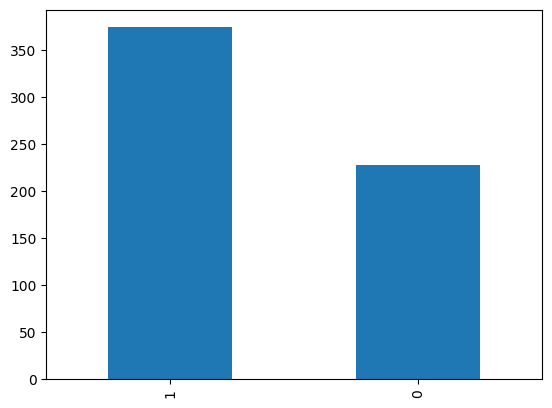

In [33]:
test_df['category'].value_counts().plot.bar()

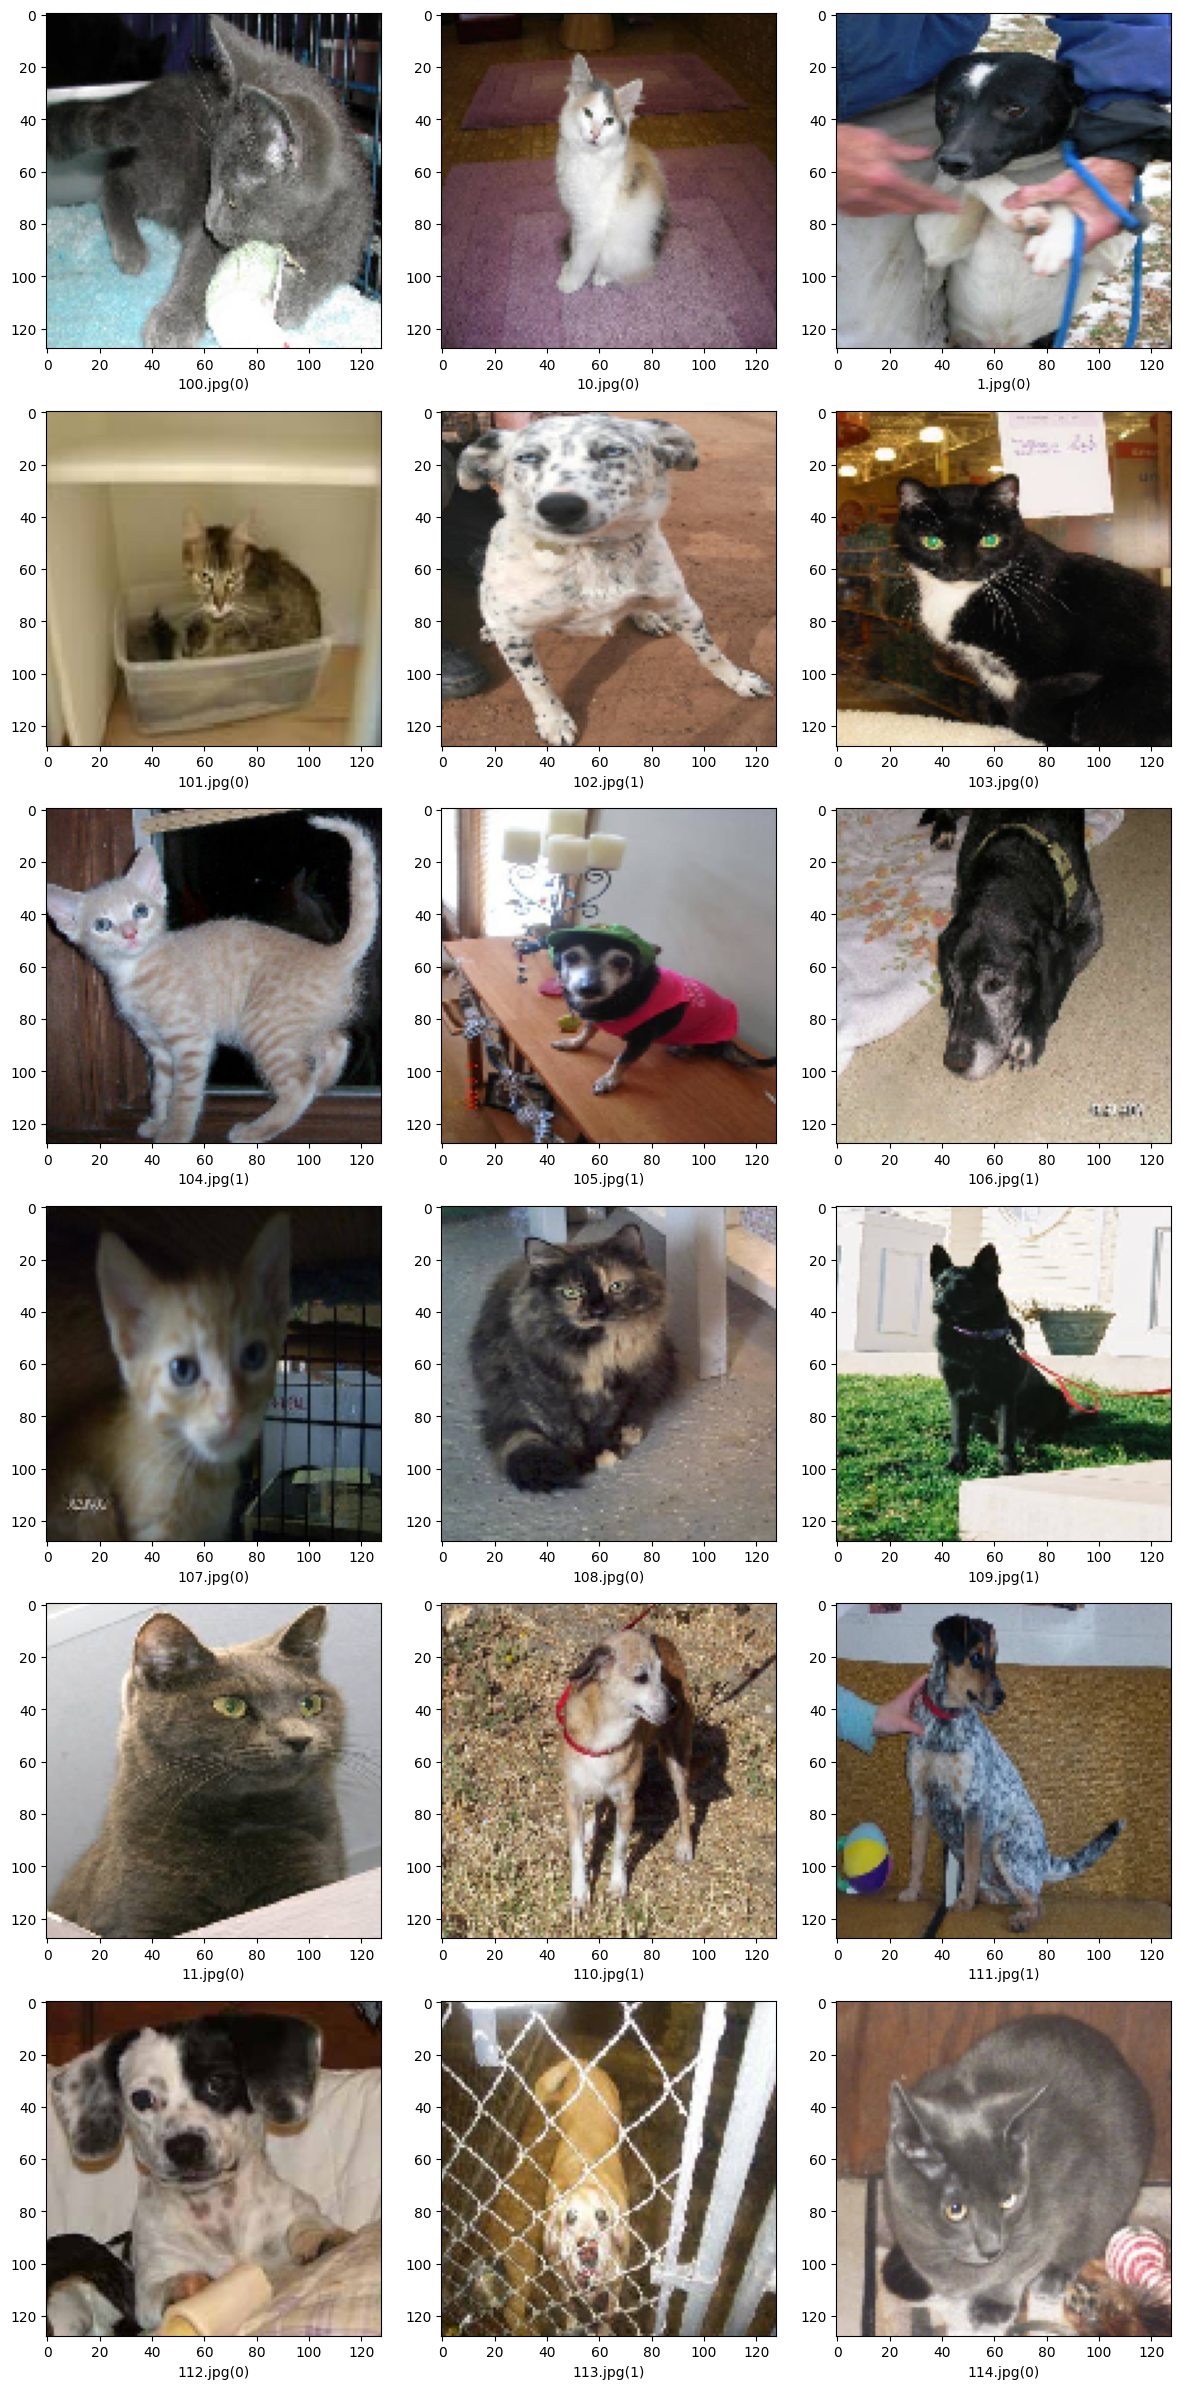

In [35]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/Dog or Cat/test_600/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [36]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)